In [2]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import mediapipe as mp
import cv2
import time

# 1.KEYPOINTS HOLISTIC

In [4]:
mp_holistic = mp.solutions.holistic
mp_draw = mp.solutions.drawing_utils

In [5]:
def feature_detect(image,model):
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    result = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image,cv2.COLOR_RGB2BGR)
    return result

In [6]:
##drawing standart land_marks on image
def draw_features(image,features):
    mp_draw.draw_landmarks(image,features.face_landmarks,mp_holistic.FACE_CONNECTIONS)
    mp_draw.draw_landmarks(image,features.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
    mp_draw.draw_landmarks(image,features.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS)
    mp_draw.draw_landmarks(image,features.pose_landmarks,mp_holistic.POSE_CONNECTIONS)

In [7]:
##creating stylish land_marks on image
def draw_styled_features(image,features):
    mp_draw.draw_landmarks(image,features.face_landmarks,mp_holistic.FACE_CONNECTIONS,
                          mp_draw.DrawingSpec(color=(165,178,50),thickness=1,circle_radius=2),
                          mp_draw.DrawingSpec(color=(165,178,50),thickness=1,circle_radius=1))
    mp_draw.draw_landmarks(image,features.right_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                          mp_draw.DrawingSpec(color=(165,178,50),thickness=2,circle_radius=2),
                          mp_draw.DrawingSpec(color=(165,178,50),thickness=2,circle_radius=3))
    mp_draw.draw_landmarks(image,features.left_hand_landmarks,mp_holistic.HAND_CONNECTIONS,
                          mp_draw.DrawingSpec(color=(165,178,50),thickness=2,circle_radius=2),
                          mp_draw.DrawingSpec(color=(165,178,50),thickness=2,circle_radius=3))
    mp_draw.draw_landmarks(image,features.pose_landmarks,mp_holistic.POSE_CONNECTIONS,
                          mp_draw.DrawingSpec(color=(243,11,11),thickness=4,circle_radius=2),
                          mp_draw.DrawingSpec(color=(42,243,11),thickness=2,circle_radius=5))

In [ ]:
cap = cv2.VideoCapture(-1)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as model:
    while cap.isOpened():
        ret,frame = cap.read()
        
        result= feature_detect(frame,model)
        draw_styled_features(frame,result)
        cv2.imshow('Myimage',frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
mp_draw.draw_landmarks??

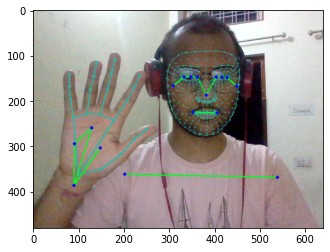

In [ ]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [ ]:
print("No of landmarks on right hand: ",len(result.right_hand_landmarks.landmark))
print("No of landmarks on left hand: ",len(result.right_hand_landmarks.landmark))
print("No of landmarks on face: ",len(result.face_landmarks.landmark))
print("No of landmarks on pose: ",len(result.pose_landmarks.landmark))
print("No of total landmarks: ",len(result.face_landmarks.landmark)+2*len(result.right_hand_landmarks.landmark)+len(result.pose_landmarks.landmark))
print("total number of features: ",len(result.right_hand_landmarks.landmark),"*3+",len(result.right_hand_landmarks.landmark),"*3+",len(result.face_landmarks.landmark),"*3+",len(result.pose_landmarks.landmark),"*4:",len(result.right_hand_landmarks.landmark)*6+len(result.face_landmarks.landmark)*3+len(result.pose_landmarks.landmark)*4)

No of landmarks on right hand:  21
No of landmarks on left hand:  21
No of landmarks on face:  468
No of landmarks on pose:  33
No of total landmarks:  543
total number of features:  21 *3+ 21 *3+ 468 *3+ 33 *4: 1662


In [8]:
def extract_features(result):
    pose = np.array([[res.x,res.y,res.z,res.visibility] for res in result.pose_landmarks.landmark]).flatten() if result.pose_landmarks else np.zeros(33*4)
    #print("shape of pose_features: ",pose.shape )
    face = np.array([[res.x,res.y,res.z] for res in result.face_landmarks.landmark]).flatten() if result.face_landmarks else np.zeros(468*3)
    #print("shape of face_features: ",face.shape )
    lefth = np.array([[res.x,res.y,res.z] for res in result.left_hand_landmarks.landmark]).flatten() if result.left_hand_landmarks else np.zeros(21*3)
    #print("shape of left hand_features: ",lefth.shape )
    righth = np.array([[res.x,res.y,res.z] for res in result.right_hand_landmarks.landmark]).flatten() if result.right_hand_landmarks else np.zeros(21*3)
    #print("shape of right hand_features: ",righth.shape )
    return np.concatenate((pose,face,lefth,righth))

In [ ]:
extract_features(result).shape

(1662,)

# 2. Collection of dataset

In [9]:
dir_path = "SLD_dataset"
os.mkdir(dir_path)

##actions to be recognised
actions = ["thank you","hello","i love you"]
##no of videos per action
nexamples = 30
##no of framses per video
nframes = 30


In [ ]:
##making directories for storing training data
for action in actions:
    subdir = os.path.join(dir_path,action)
    os.mkdir(subdir)
    for i in range(nexamples):
        sample_path = os.path.join(subdir,str(i))
        os.mkdir(sample_path)

In [ ]:
cap = cv2.VideoCapture(-1)

with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as model:
    for action in actions:
        for i in range(nexamples):
            for j in range(nframes+1):
                ret,image = cap.read()
                
                result = feature_detect(image,model)
                draw_styled_features(image,result)
                if i==0 and j==0:
                    cv2.putText(image,'Action:{}'.format(action),(120,200),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255.0,0),4,cv2.LINE_AA)
                    cv2.imshow("collecting Data",image)
                    cv2.waitKey(5000)
                elif j==0:
                    cv2.putText(image,'Wait',(120,200),cv2.FONT_HERSHEY_SIMPLEX,1,(0,255.0,0),4,cv2.LINE_AA)
                    cv2.imshow("collecting Data",image)
                    cv2.waitKey(1000)
                else:
                    cv2.putText(image,'collecting frames for action {} video number {}'.format(action,i),(15,12),cv2.FONT_HERSHEY_SIMPLEX,0.5,(0,0,255.0),1,cv2.LINE_AA)
                    #saving the features for a frame in a .npy file
                    np.save(os.path.join(dir_path,action,str(i),str(j)),extract_features(result))
                    
                cv2.imshow("collecting Data",image)
                
                #breaking sataement
                if cv2.waitKey(1)& 0xFF == ord('q'):
                    break;
            if cv2.waitKey(1)& 0xFF == ord('q'):
                break;
        if cv2.waitKey(1)& 0xFF == ord('q'):
            break;
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
cap.release()
cv2.destroyAllWindows()

# 3. Preprocessing the data

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

In [11]:
#creating interger labels for the actions
action_map = {action:num for num,action in enumerate(actions)}
action_map

{'thank you': 0, 'hello': 1, 'i love you': 2}

In [ ]:
##concatenating the dataset
data = []
label = []
for action in os.listdir(dir_path):
    for video in range(nexamples):
        window = []
        for i in range(1,nframes+1):
            res = np.load(os.path.join(dir_path,action,str(video),str(i)+".npy"))
            window.append(res)
        window = np.array(window)
        data.append(window)
        label.append(action_map[action])

In [ ]:
data = np.array(data)
target = to_categorical(label)
print(data.shape)
print(target.shape)

(90, 30, 1662)
(90, 3)


In [12]:
target = np.load('target.npy')
data = np.load('data.npy')

In [24]:
x_train,x_test,y_train,y_test = train_test_split(data,target,test_size=0.1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(81, 30, 1662)
(9, 30, 1662)
(81, 3)
(9, 3)


# 3. Building and Training the Model using LSTM

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.callbacks import TensorBoard

In [62]:
log_dir = os.path.join('logs')
tb_callback = TensorBoard(log_dir=log_dir)

2021-07-05 17:01:17.999631: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2021-07-05 17:01:17.999706: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2021-07-05 17:01:17.999817: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-07-05 17:01:17.999869: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2021-07-05 17:01:17.999906: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1496] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


In [26]:
model = Sequential()
model.add(LSTM(64,activation='relu',return_sequences=True,input_shape=(30,1662)))
model.add(LSTM(128,return_sequences=True,activation='relu'))
model.add(LSTM(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(target[0].shape[0],activation='softmax'))

model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['categorical_accuracy'])

In [90]:
history = model.fit(x_train,y_train,epochs=300,verbose=1,validation_data=(x_test,y_test))

Epoch 1/300
3/3 [==============================] - 4s 324ms/step - loss: 1.9349 - categorical_accuracy: 0.2803 - val_loss: 1.0920 - val_categorical_accuracy: 0.4444
Epoch 2/300
3/3 [==============================] - 0s 89ms/step - loss: 1.1725 - categorical_accuracy: 0.3727 - val_loss: 0.9334 - val_categorical_accuracy: 0.4444
Epoch 3/300
3/3 [==============================] - 0s 90ms/step - loss: 1.5594 - categorical_accuracy: 0.3184 - val_loss: 0.7067 - val_categorical_accuracy: 0.6667
Epoch 4/300
3/3 [==============================] - 0s 89ms/step - loss: 1.0060 - categorical_accuracy: 0.4214 - val_loss: 0.8257 - val_categorical_accuracy: 0.6667
Epoch 5/300
3/3 [==============================] - 0s 89ms/step - loss: 0.8493 - categorical_accuracy: 0.4768 - val_loss: 0.8581 - val_categorical_accuracy: 0.3333
Epoch 6/300
3/3 [==============================] - 0s 91ms/step - loss: 0.6833 - categorical_accuracy: 0.5870 - val_loss: 0.9044 - val_categorical_accuracy: 0.5556
Epoch 7/300
3/3

Epoch 51/300
3/3 [==============================] - 0s 88ms/step - loss: 0.3381 - categorical_accuracy: 0.8517 - val_loss: 0.3728 - val_categorical_accuracy: 0.8889
Epoch 52/300
3/3 [==============================] - 0s 87ms/step - loss: 0.3103 - categorical_accuracy: 0.8797 - val_loss: 0.4815 - val_categorical_accuracy: 0.8889
Epoch 53/300
3/3 [==============================] - 0s 86ms/step - loss: 0.3101 - categorical_accuracy: 0.8791 - val_loss: 1.3113 - val_categorical_accuracy: 0.4444
Epoch 54/300
3/3 [==============================] - 0s 88ms/step - loss: 0.7043 - categorical_accuracy: 0.6722 - val_loss: 0.7133 - val_categorical_accuracy: 0.5556
Epoch 55/300
3/3 [==============================] - 0s 87ms/step - loss: 0.5500 - categorical_accuracy: 0.7639 - val_loss: 0.5521 - val_categorical_accuracy: 0.6667
Epoch 56/300
3/3 [==============================] - 0s 85ms/step - loss: 0.5384 - categorical_accuracy: 0.7766 - val_loss: 0.5781 - val_categorical_accuracy: 0.6667
Epoch 57/3

3/3 [==============================] - 0s 94ms/step - loss: 0.0770 - categorical_accuracy: 0.9659 - val_loss: 0.1464 - val_categorical_accuracy: 0.8889
Epoch 101/300
3/3 [==============================] - 0s 90ms/step - loss: 0.0389 - categorical_accuracy: 0.9837 - val_loss: 0.1030 - val_categorical_accuracy: 1.0000
Epoch 102/300
3/3 [==============================] - 0s 88ms/step - loss: 0.0362 - categorical_accuracy: 0.9938 - val_loss: 0.0548 - val_categorical_accuracy: 1.0000
Epoch 103/300
3/3 [==============================] - 0s 91ms/step - loss: 0.0501 - categorical_accuracy: 0.9938 - val_loss: 0.1044 - val_categorical_accuracy: 0.8889
Epoch 104/300
3/3 [==============================] - 0s 98ms/step - loss: 0.0962 - categorical_accuracy: 0.9759 - val_loss: 17.5942 - val_categorical_accuracy: 0.2222
Epoch 105/300
3/3 [==============================] - 0s 90ms/step - loss: 20.1313 - categorical_accuracy: 0.4784 - val_loss: 22.5007 - val_categorical_accuracy: 0.4444
Epoch 106/300
3

3/3 [==============================] - 0s 91ms/step - loss: 1.4906 - categorical_accuracy: 0.3190 - val_loss: 0.8914 - val_categorical_accuracy: 0.3333
Epoch 150/300
3/3 [==============================] - 0s 86ms/step - loss: 1.0086 - categorical_accuracy: 0.3492 - val_loss: 1.0906 - val_categorical_accuracy: 0.4444
Epoch 151/300
3/3 [==============================] - 0s 86ms/step - loss: 0.9536 - categorical_accuracy: 0.6033 - val_loss: 1.1139 - val_categorical_accuracy: 0.4444
Epoch 152/300
3/3 [==============================] - 0s 85ms/step - loss: 0.8916 - categorical_accuracy: 0.6111 - val_loss: 1.0224 - val_categorical_accuracy: 0.4444
Epoch 153/300
3/3 [==============================] - 0s 87ms/step - loss: 0.8272 - categorical_accuracy: 0.6234 - val_loss: 0.9792 - val_categorical_accuracy: 0.4444
Epoch 154/300
3/3 [==============================] - 0s 86ms/step - loss: 0.8021 - categorical_accuracy: 0.5860 - val_loss: 0.8781 - val_categorical_accuracy: 0.7778
Epoch 155/300
3/3 

3/3 [==============================] - 0s 96ms/step - loss: 0.3106 - categorical_accuracy: 0.8472 - val_loss: 0.6587 - val_categorical_accuracy: 0.6667
Epoch 199/300
3/3 [==============================] - 0s 91ms/step - loss: 0.3187 - categorical_accuracy: 0.8807 - val_loss: 0.3812 - val_categorical_accuracy: 0.7778
Epoch 200/300
3/3 [==============================] - 0s 94ms/step - loss: 0.4687 - categorical_accuracy: 0.7668 - val_loss: 0.8462 - val_categorical_accuracy: 0.6667
Epoch 201/300
3/3 [==============================] - 0s 96ms/step - loss: 0.4257 - categorical_accuracy: 0.7600 - val_loss: 0.4497 - val_categorical_accuracy: 0.7778
Epoch 202/300
3/3 [==============================] - 0s 91ms/step - loss: 0.3620 - categorical_accuracy: 0.8338 - val_loss: 0.5564 - val_categorical_accuracy: 0.8889
Epoch 203/300
3/3 [==============================] - 0s 95ms/step - loss: 0.3563 - categorical_accuracy: 0.8579 - val_loss: 0.3954 - val_categorical_accuracy: 0.7778
Epoch 204/300
3/3 

3/3 [==============================] - 0s 93ms/step - loss: 0.2598 - categorical_accuracy: 0.8651 - val_loss: 0.2685 - val_categorical_accuracy: 0.7778
Epoch 248/300
3/3 [==============================] - 0s 92ms/step - loss: 0.2846 - categorical_accuracy: 0.8819 - val_loss: 0.4031 - val_categorical_accuracy: 0.7778
Epoch 249/300
3/3 [==============================] - 0s 95ms/step - loss: 0.1912 - categorical_accuracy: 0.9194 - val_loss: 0.3838 - val_categorical_accuracy: 0.8889
Epoch 250/300
3/3 [==============================] - 0s 89ms/step - loss: 0.3400 - categorical_accuracy: 0.8361 - val_loss: 0.3073 - val_categorical_accuracy: 0.8889
Epoch 251/300
3/3 [==============================] - 0s 94ms/step - loss: 0.2358 - categorical_accuracy: 0.8969 - val_loss: 0.3187 - val_categorical_accuracy: 0.8889
Epoch 252/300
3/3 [==============================] - 0s 90ms/step - loss: 0.1984 - categorical_accuracy: 0.9294 - val_loss: 0.3183 - val_categorical_accuracy: 0.7778
Epoch 253/300
3/3 

3/3 [==============================] - 0s 99ms/step - loss: 0.7023 - categorical_accuracy: 0.7304 - val_loss: 0.7595 - val_categorical_accuracy: 0.4444
Epoch 297/300
3/3 [==============================] - 0s 98ms/step - loss: 0.3830 - categorical_accuracy: 0.8098 - val_loss: 0.4710 - val_categorical_accuracy: 0.7778
Epoch 298/300
3/3 [==============================] - 0s 96ms/step - loss: 0.3459 - categorical_accuracy: 0.8494 - val_loss: 0.5361 - val_categorical_accuracy: 0.8889
Epoch 299/300
3/3 [==============================] - 0s 89ms/step - loss: 0.3614 - categorical_accuracy: 0.8556 - val_loss: 0.7317 - val_categorical_accuracy: 0.4444
Epoch 300/300
3/3 [==============================] - 0s 96ms/step - loss: 0.3325 - categorical_accuracy: 0.8501 - val_loss: 0.0879 - val_categorical_accuracy: 1.0000


In [27]:
def visualize(history,iterations):
  iter = range(iterations)
  plt.figure()
  plt.plot(iter,history.history["loss"],label= 'train_loss')
  plt.plot(iter,history.history["val_loss"],label = 'test_loss')
  plt.figure()
  plt.plot(iter,history.history["categorical_accuracy"],label = 'train_accuracy')
  plt.plot(iter,history.history["val_categorical_accuracy"],label='test_accuracy')
  plt.legend()


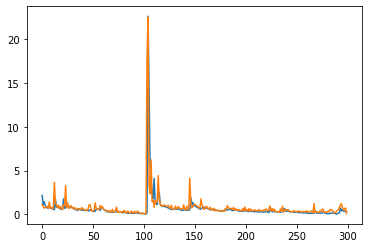

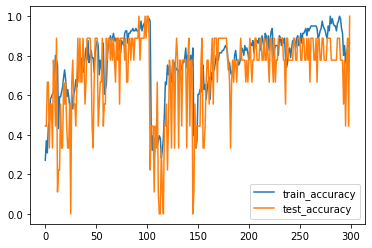

In [92]:
visualize(history,300)

In [93]:
model.save('action.h5')

In [28]:
model.load_weights('action.h5')
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 30, 64)            442112    
_________________________________________________________________
lstm_10 (LSTM)               (None, 30, 128)           98816     
_________________________________________________________________
lstm_11 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_10 (Dense)             (None, 20)                1300      
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 63        
Total params: 595,859
Trainable params: 595,859
Non-trainable params: 0
________________________________________________

In [29]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

yhat = np.argmax(model.predict(x_test),axis=1)
ytrue = np.argmax(y_test,axis=1)
print(multilabel_confusion_matrix(ytrue,yhat))
print(accuracy_score(ytrue,yhat))

[[[5 1]
  [0 3]]

 [[8 0]
  [0 1]]

 [[4 0]
  [1 4]]]
0.8888888888888888


In [30]:
def viz_labels(labels,actions,threshold,sentence,frame):
    label = np.argmax(labels,axis=1)[0]
    if labels[0][label]>threshold:
            if len(sentence)>0:
                if actions[label]!=sentence[-1]:
                    sentence.append(actions[label])
            else:
                sentence.append(actions[label])
            sentence = sentence[-5:]
    cv2.rectangle(frame,(0,0),(640,40),(255,15,0),-1)
    cv2.putText(frame,''.join(sentence),(3,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
    return frame

In [40]:
def prob_viz(labels,actions,frame):
    colors = [(245,117,16),(117,245,16),(16,117,245)]
    for i,prob in enumerate(labels[0]):
        cv2.rectangle(frame,(0,60+40*i),(int(prob*100),90+40*i),colors[i],-1)
        cv2.putText(frame,actions[i],(0,85+40*i),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2,cv2.LINE_AA)
    return frame

# 4. Testing in Real Time

In [41]:
sequence = []
sentence = []
threshold = 0.6
cap = cv2.VideoCapture(-1)
with mp_holistic.Holistic(min_detection_confidence=0.5,min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():
        
        ret, frame = cap.read()
        result = feature_detect(frame,holistic)
        draw_styled_features(frame,result)
        sequence.append(extract_features(result))
        sequence = sequence[-30:]
        if len(sequence)==30:   
            labels = model.predict(np.array(sequence).reshape(1,30,1662))
            #label = np.argmax(labels,axis=1)[0]
#             print(actions[label])
            frame = prob_viz(labels,actions,frame)
            
        #viz label
        #frame = viz_labels(labels,actions,threshold,sentence,frame)
        
        cv2.imshow('output',frame)
        
        if cv2.waitKey(1)& 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [37]:
cap.release()
cv2.destroyAllWindows()